## Are coexpression groups in relative orientations we'd expect?

Both a starting point to look at Tami's coexpression clusters, as well as answering above question


start in one tissue "whole_blood", build pipeline, then expand to others

In [89]:
# import packages
import numpy as np
import pandas as pd
import pyranges as pr
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import spearmanr
import sys
sys.path.append('/home/klawren/oak/pcqtls/workflow/scripts')
import scipy as sp

from residualize import calculate_residual

In [40]:
# get outputs from a config file
prefix = '/home/klawren/oak/pcqtls'
import yaml
config_path= f'{prefix}/config/pcqtl_proteincoding.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

tissue_id_path = config['tissue_id_path']
clusters_dir = config['clusters_dir']
expression_dir = config['expression_dir']
covariates_dir = config['covariates_dir']

# load in the tissue ids 
tissue_df = pd.read_csv(f"{prefix}/{tissue_id_path}", header=0)
tissue_ids = list(tissue_df['Tissue'])
tissue_id = 'Lung'

## correlation between all pairs based on orrientaiton

In [41]:
# load in expression data (so we only compare to pairs of genes also expressed in this tissue)
# load in gene expression data
expression_df = pd.read_csv(f'{prefix}/{expression_dir}/{tissue_id}.v8.normalized_expression.bed', sep='\t')

covariates_df = pd.read_csv(f'{prefix}/{covariates_dir}/{tissue_id}.v8.covariates.txt', sep='\t', index_col=0).T

# residulize the expression 
residal_exp = calculate_residual(expression_df[covariates_df.index], covariates_df, center=True)
residal_exp = pd.DataFrame(residal_exp, columns=covariates_df.index, index=expression_df['gene_id'])

In [44]:
# load in the gene information (start and strand are what I need)
full_gencode=pd.read_csv('/home/klawren/oak/pcqtls/data/references/processed_gencode.v26.GRCh38.genes.gtf', sep='\t', skiprows=range(6), 
            header=None, names=['chr', 'dataset', 'type', 'start','end', '.', 'strand', 'na', 'info'])

full_gencode = full_gencode[full_gencode['type']=='transcript']
full_gencode['transcript_id'] = full_gencode['info'].str.split(';').str[1].str.split('\"').str[-2]

# add in the start and end info
full_gencode['tss_start'] = np.where(full_gencode['strand'] == '+', full_gencode['start'], full_gencode['end'])
full_gencode['gene_end'] = np.where(full_gencode['strand'] == '-', full_gencode['start'], full_gencode['end'])



In [64]:
# df of each pair , strands and corr
# get downstream orentation information
# these must be numpy arrays not pd series
def get_orr(strands1, strands2):
    orrs = pd.Series(['tandem']*len(strands1))
    # where they are different, conv or div based on the downstream gene identity
    orrs = orrs.mask(strands1 != strands2, np.where(strands1 == '-', 'divergent', 'convergent'))
    return orrs.values

In [91]:
def annotate_gencode_chr(chr_id):
    chr_expression = residal_exp.loc[expression_df[expression_df['#chr']==f'chr{chr_id}']['gene_id']]

    chr_corr, chr_pvalue = spearmanr(chr_expression, axis=1)
    chr_corr = pd.DataFrame(chr_corr, index=chr_expression.index, columns=chr_expression.index)
    chr_pvalue = pd.DataFrame(chr_pvalue, index=chr_expression.index, columns=chr_expression.index)
    # filter to just the transcripts that are in the clusters
    gid_gencode = full_gencode.set_index('transcript_id').loc[chr_expression.index]
    gid_gencode = gid_gencode.drop_duplicates()

    # gene to gene distance
    gid_gencode['distance'] = gid_gencode['tss_start'].shift(-1) - gid_gencode['tss_start']
    # gene to gene correlation
    gid_gencode['downstream_corr'] = np.concatenate([np.diagonal(chr_corr, offset=1), [0]])
    gid_gencode['downstream_orientation'] = get_orr(gid_gencode['strand'].values, gid_gencode.shift(-1)['strand'].values)
    return gid_gencode[['distance', 'downstream_corr', 'downstream_orientation']].reset_index().iloc[:-1]

In [93]:
orr_df = pd.concat([annotate_gencode_chr(i) for i in range(1,23,1)]).reset_index()

<AxesSubplot: xlabel='downstream_corr', ylabel='Density'>

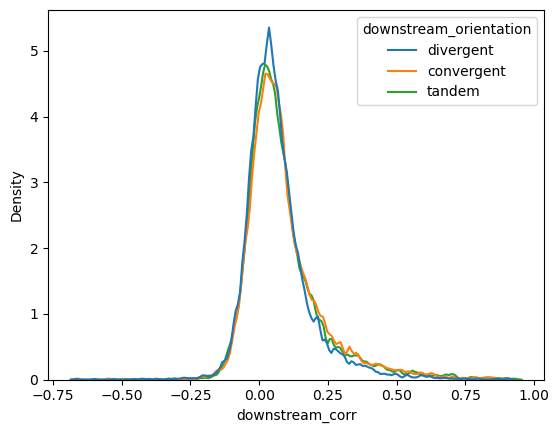

In [75]:
sns.kdeplot(orr_df, x='downstream_corr', hue='downstream_orientation', bw_adjust=.3, common_norm=False)

<AxesSubplot: xlabel='downstream_corr', ylabel='Percent'>

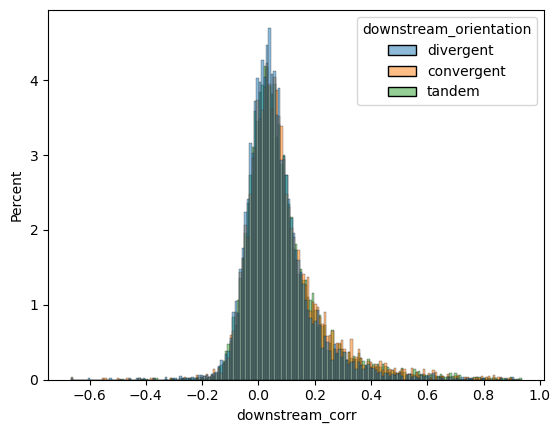

In [77]:
sns.histplot(orr_df, x='downstream_corr', hue='downstream_orientation', stat='percent', common_norm=False)

resample to match distances between orientaitons

<AxesSubplot: xlabel='distance', ylabel='Density'>

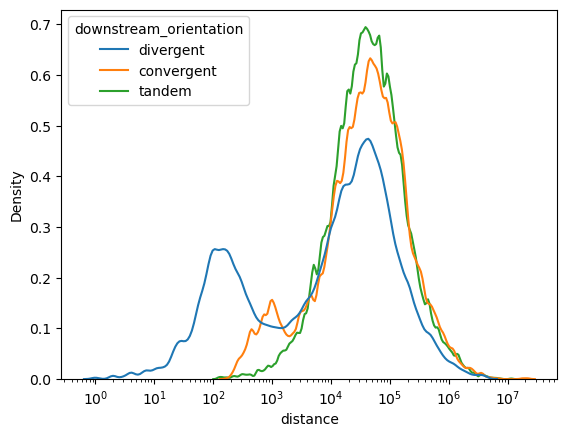

In [81]:
# distance distributions (tss-tss)
sns.kdeplot(orr_df, x='distance', hue='downstream_orientation', bw_adjust=.3, common_norm=False, log_scale=(10,None))

<AxesSubplot: xlabel='downstream_corr', ylabel='Density'>

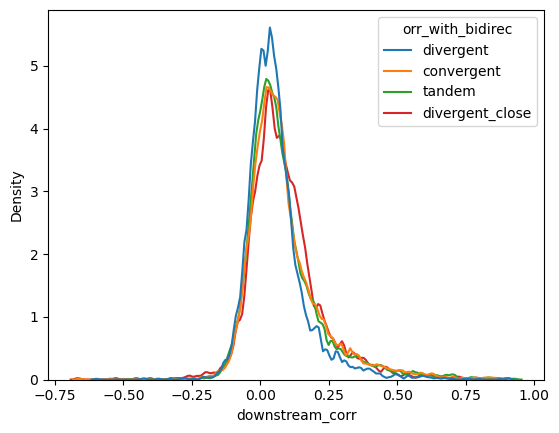

In [127]:
# check if the close divergent are more likely to be coexpressed
orr_df['orr_with_bidirec'] = orr_df['downstream_orientation']
orr_df.loc[(orr_df['downstream_orientation']=='divergent')&(orr_df['distance'] <1000),'orr_with_bidirec'] = 'divergent_close'
sns.kdeplot(orr_df, x='downstream_corr', hue='orr_with_bidirec', bw_adjust=.3, common_norm=False)

In [82]:
# code from ben
# target has to be smaller or the two, n is length of target

def resample_dist(target, candidate_pool, n, seed=126124):   
    """Match a target distribution via weighted sampling from a candidate pool
    Args:
        target, candidate_pool: 1D numpy arrays with values ranging from 0 to 1
        n: integer number of indices to return
    Return:
        n indices to elements candidate_pool to use for the sample
    """
    rng = np.random.default_rng(seed)
    target_prob = sp.stats.gaussian_kde(target)
    candidate_prob = sp.stats.gaussian_kde(candidate_pool)

    bins = np.arange(0, 1, 0.0001)
    sampling_weight = target_prob(bins) / candidate_prob(bins)
    pool_bins = np.searchsorted(bins, candidate_pool) - 1
    pool_probability = sampling_weight[pool_bins]/sampling_weight[pool_bins].sum()

    return rng.choice(candidate_pool.size, size=n, replace=True, p=pool_probability)

In [111]:
orr_df['normed_log_dist'] = np.log10(orr_df['distance'])/np.log10(orr_df['distance'].max())

tandem_idxs = resample_dist(orr_df['normed_log_dist'], orr_df[orr_df['downstream_orientation']=='tandem']['normed_log_dist'], n=10000)
convergent_idxs = resample_dist(orr_df['normed_log_dist'], orr_df[orr_df['downstream_orientation']=='convergent']['normed_log_dist'], n=10000)
divergent_idxs = resample_dist(orr_df['normed_log_dist'], orr_df[orr_df['downstream_orientation']=='divergent']['normed_log_dist'], n=10000)


In [112]:
resamp_orr = pd.concat([orr_df[orr_df['downstream_orientation']=='tandem'].reset_index().iloc[tandem_idxs], 
                        orr_df[orr_df['downstream_orientation']=='convergent'].reset_index().iloc[convergent_idxs], 
                        orr_df[orr_df['downstream_orientation']=='divergent'].reset_index().iloc[divergent_idxs]])

<AxesSubplot: xlabel='distance', ylabel='Density'>

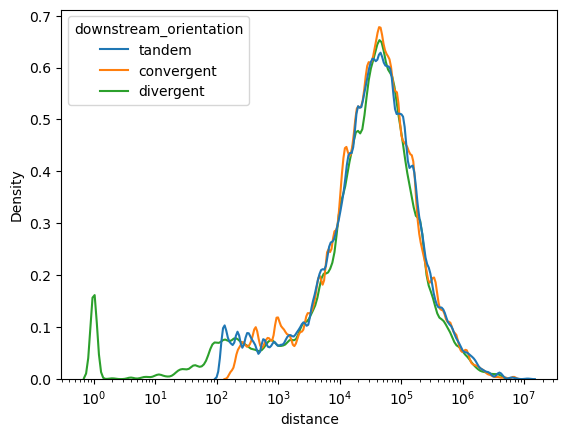

In [113]:
sns.kdeplot(resamp_orr, x='distance', hue='downstream_orientation', bw_adjust=.3, common_norm=False, log_scale=(10,None))

<AxesSubplot: xlabel='downstream_corr', ylabel='Density'>

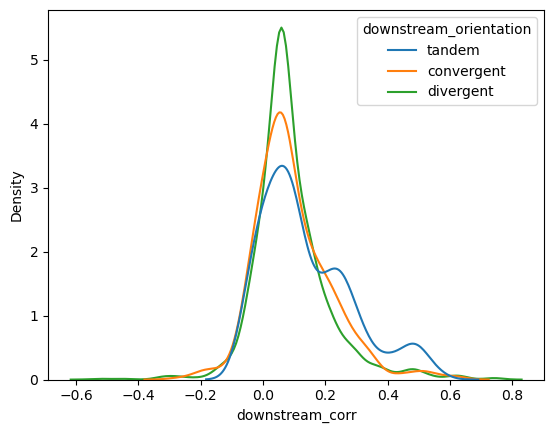

In [128]:
sns.kdeplot(resamp_orr[resamp_orr['distance']<1000], x='downstream_corr', hue='downstream_orientation', common_norm=False)

## clusters orrientaiton

In [4]:
# get the coexpression groups
clusters = pd.read_csv(f'{prefix}/{clusters_dir}/{tissue_id}_clusters_all_chr.csv', index_col=0)

# data from all chromosomes combined
clusters.head()

,N_genes,Transcripts,Genes,Perc_cor,Mean_cor,Mean_pos_cor,Mean_neg_cor,Chromosome,Tissue
0,13,"ENSG00000143631.10,ENSG00000143520.6,ENSG00000...","FLG2, CRNN, FLG, IVL, SPRR3, SPRR2D, SPRR1B, S...",73.077,0.419,0.419,NaN,1,Lung
1,7,"ENSG00000169474.4,ENSG00000163209.14,ENSG00000...","SPRR2G, SPRR3, SPRR2D, SPRR1B, SPRR1A, SPRR2E,...",76.190,0.472,0.472,NaN,1,Lung
2,5,"ENSG00000117228.9,ENSG00000162645.12,ENSG00000...","GBP1, GBP5, GBP2, GBP4, GBP7",70.000,0.352,0.352,NaN,1,Lung
3,5,"ENSG00000168765.16,ENSG00000213366.12,ENSG0000...","GSTM1, GSTM5, GSTM3, GSTM4, GSTM2",100.000,0.527,0.527,NaN,1,Lung
4,5,"ENSG00000203812.2,ENSG00000272196.2,ENSG000001...","HIST2H2AC, HIST2H2AB, HIST2H2BE, HIST2H2AA3, H...",80.000,0.308,0.308,NaN,1,Lung


In [5]:
# direction of genes within groups
# download the gene list to get strand information
gtf_path = '/oak/stanford/groups/smontgom/tami/eqtl_project/data/gencode.v26.GRCh38.genes.gtf'

full_g = pr.read_gtf(gtf_path)
transcript_df = full_g[full_g.Feature == 'transcript'].df
transcript_df.head()

,Chromosome,Source,Feature,Start,End,Score,Strand,Frame,gene_id,transcript_id,gene_type,gene_name,transcript_type,transcript_name,level,havana_gene,exon_id,exon_number,tag
0,chr1,HAVANA,transcript,11868,14403,.,+,.,ENSG00000223972.5,ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,transcribed_unprocessed_pseudogene,DDX11L1,2,OTTHUMG00000000961.2,NaN,NaN,NaN
1,chr1,HAVANA,transcript,29570,31109,.,+,.,ENSG00000243485.5,ENSG00000243485.5,lincRNA,MIR1302-2HG,lincRNA,MIR1302-2HG,2,OTTHUMG00000000959.2,NaN,NaN,ncRNA_host
2,chr1,HAVANA,transcript,52472,53312,.,+,.,ENSG00000268020.3,ENSG00000268020.3,unprocessed_pseudogene,OR4G4P,unprocessed_pseudogene,OR4G4P,2,OTTHUMG00000185779.1,NaN,NaN,NaN
3,chr1,HAVANA,transcript,62947,63887,.,+,.,ENSG00000240361.1,ENSG00000240361.1,unprocessed_pseudogene,OR4G11P,unprocessed_pseudogene,OR4G11P,2,OTTHUMG00000001095.2,NaN,NaN,NaN
4,chr1,HAVANA,transcript,69090,70008,.,+,.,ENSG00000186092.4,ENSG00000186092.4,protein_coding,OR4F5,protein_coding,OR4F5,2,OTTHUMG00000001094.2,NaN,NaN,NaN


In [50]:
# add strand information to dataframe 
def frac_same_strand(row):
    ids = row.Transcripts.split(',')
    s = transcript_df[transcript_df.transcript_id.isin(ids)].Strand
    return sum(s=='+')/len(s)

<Axes: xlabel='Mean_cor', ylabel='frac_pos_strand'>

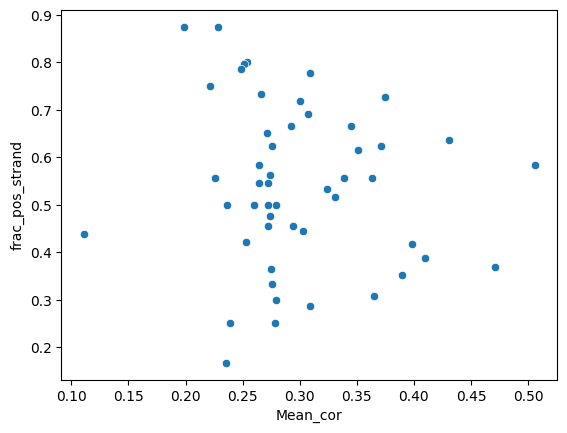

In [63]:
# not a lot to see when we look at the correlations in the cluster as a whole

clusters['frac_pos_strand'] = clusters.apply(frac_same_strand, axis=1) 
sns.scatterplot(clusters, x='Mean_cor', y='frac_pos_strand')

In [112]:
# look at one away from diagonal pairs and the relative orientations
# for this I need the actually gene-gene cors
# they appear to be sorted such that G1 tss is always upstream of g2 tss

corr_path = '/oak/stanford/groups/smontgom/tami/eqtl_project/output/1_correlations/Whole_Blood/sig_corr_df_chr1_yes_covars_0pc_60peers_w_distances.csv'
corr_1 = pd.read_csv(corr_path)
corr_1.head()

,Gene1,Gene2,Corr_coefficient,P,Gene1_name,G1_start,G1_end,G1_distance_rank,G1_distance_exp_rank,Gene2_name,G2_start,G2_end,G2_distance_rank,G2_distance_exp_rank
0,ENSG00000000938.12,ENSG00000116337.15,0.202690,1.053440e-09,FGR,27612064,27635277,843,403,AMPD2,109619504,109632051,2338,999
1,ENSG00000000938.12,ENSG00000158869.10,0.216572,1.044002e-09,FGR,27612064,27635277,843,403,FCER1G,161215234,161220699,3401,1508
2,ENSG00000004455.16,ENSG00000135823.13,0.190045,2.095031e-08,AK2,33007940,33080996,1013,494,STX6,180972712,181023121,3791,1648
3,ENSG00000007933.12,ENSG00000117601.13,0.311193,5.765876e-18,FMO3,171090877,171117819,3610,1588,SERPINC1,173903804,173917378,3671,1610
4,ENSG00000007968.6,ENSG00000133069.15,0.209637,4.101742e-09,E2F2,23506430,23531220,693,321,TMCC2,205228176,205273343,4175,1788


In [113]:
corr_1['Gene1_strand'] = transcript_df.set_index('transcript_id').loc[corr_1['Gene1']].Strand.values
corr_1['Gene2_strand'] = transcript_df.set_index('transcript_id').loc[corr_1['Gene2']].Strand.values

In [114]:
# get downstream orentation information
def get_orr(strands1, strands2):
    orrs = pd.Series(['tandem']*len(strands1))
    # where they are different, conv or div based on the downstream gene identity
    orrs = orrs.mask(strands1 != strands2, np.where(strands1 == '-', 'divergent', 'convergent'))
    return orrs

corr_1['orr'] = get_orr(corr_1['Gene1_strand'], corr_1['Gene2_strand'])

<Axes: xlabel='orr', ylabel='Corr_coefficient'>

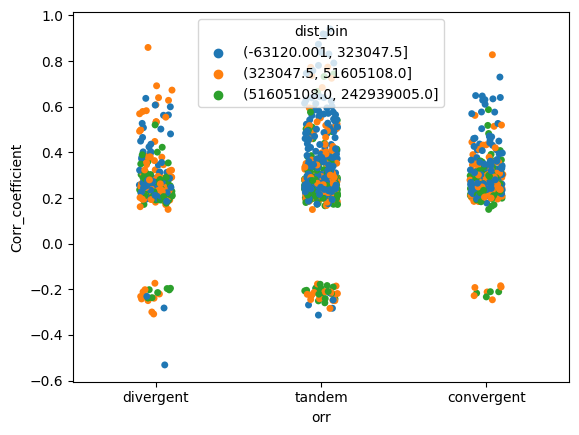

In [123]:
corr_1['center_dist'] = (corr_1['G2_start'] + corr_1['G2_end']) / 2 -(corr_1['G1_start'] + corr_1['G1_end']) / 2
corr_1['dist_bin'] = pd.qcut(corr_1['center_dist'], 3)
sns.stripplot(corr_1, y='Corr_coefficient', x='orr', hue='dist_bin')

In [140]:
# combine over multiple chromosomes
corr_list=[]
for i in range(23):
    corr_path = '/oak/stanford/groups/smontgom/tami/eqtl_project/output/1_correlations/Whole_Blood/sig_corr_df_chr{}_yes_covars_0pc_60peers_w_distances.csv'.format(i)
    try: 
        corr_df = pd.read_csv(corr_path)
            # add strands
        corr_df['Gene1_strand'] = transcript_df.set_index('transcript_id').loc[corr_df['Gene1']].Strand.values
        corr_df['Gene2_strand'] = transcript_df.set_index('transcript_id').loc[corr_df['Gene2']].Strand.values

        # add orrientation
        corr_df['orr'] = get_orr(corr_df['Gene1_strand'], corr_df['Gene2_strand'])

        # add distance 
        corr_df['center_dist'] = (corr_df['G2_start'] + corr_df['G2_end']) / 2 -(corr_df['G1_start'] + corr_df['G1_end']) / 2

        corr_list.append(corr_df)
    except FileNotFoundError:
        print('no file at {}'.format(corr_path))

no file at /oak/stanford/groups/smontgom/tami/eqtl_project/output/1_correlations/Whole_Blood/sig_corr_df_chr0_yes_covars_0pc_60peers_w_distances.csv


<Axes: xlabel='orr', ylabel='Corr_coefficient'>

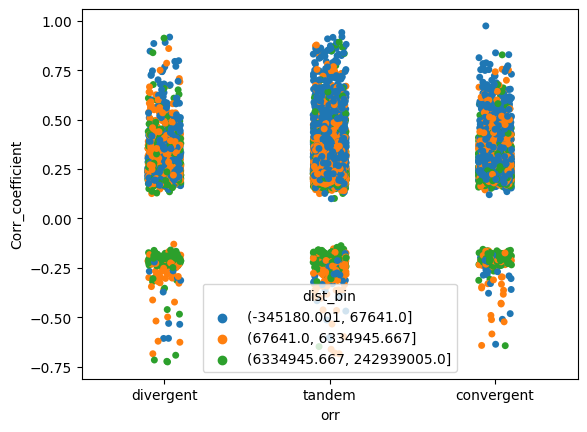

In [141]:
corr_df = pd.concat(corr_list)
corr_df['dist_bin'] = pd.qcut(corr_df['center_dist'], 3)

sns.stripplot(corr_df, y='Corr_coefficient', x='orr', hue='dist_bin')

In [182]:
# combine over multiple chromosomes, and multiple tissues

for tissue in os.listdir('/oak/stanford/groups/smontgom/tami/eqtl_project/output/1_correlations/'):
    print(tissue)
    corr_list=[]
    for chri in range(24):
        corr_path = '/oak/stanford/groups/smontgom/tami/eqtl_project/output/1_correlations/{}/sig_corr_df_chr{}_yes_covars_0pc_60peers_w_distances.csv'.format(tissue, chri)
        try: 
            corr_df = pd.read_csv(corr_path)
                # add strands
            corr_df['Gene1_strand'] = transcript_df.set_index('transcript_id').loc[corr_df['Gene1']].Strand.values
            corr_df['Gene2_strand'] = transcript_df.set_index('transcript_id').loc[corr_df['Gene2']].Strand.values

            # add orrientation
            corr_df['orr'] = get_orr(corr_df['Gene1_strand'], corr_df['Gene2_strand'])

            # add distance 
            corr_df['center_dist'] = (corr_df['G2_start'] + corr_df['G2_end']) / 2 -(corr_df['G1_start'] + corr_df['G1_end']) / 2

            corr_list.append(corr_df)
        except FileNotFoundError:
            pass
            #print('no file at {}'.format(corr_path))
    
    corr_df = pd.concat(corr_list)       
    # only take pairs less than 50kb apart
    corr_df = corr_df[corr_df['center_dist']<50000]
    frac_neg = pd.Series(dtype='float64')
    for o in corr_df.orr.unique():
        frac_neg[o] = sum(corr_df[corr_df['orr'] == o]['Corr_coefficient'] < 0)/len(corr_df[corr_df['orr'] ==o])

    try:
        across_tissue_corr.loc[tissue] = frac_neg
    except NameError:
        # for the first tissue, make the df
        across_tissue_corr=pd.DataFrame.from_dict({tissue:frac_neg}).transpose()


Skin_Not_Sun_Exposed_Suprapubic
Muscle_Skeletal
Adipose_Visceral_Omentum
Skin_Sun_Exposed_Lower_leg
Whole_Blood
Esophagus_Muscularis
Thyroid
Lung
Nerve_Tibial
Cells_Cultured_fibroblasts
Esophagus_Mucosa
Artery_Tibial
Adipose_Subcutaneous


In [183]:
across_tissue_corr

,tandem,convergent,divergent
Wholeblood,0.022059,0.027682,0.015625
Skin_Not_Sun_Exposed_Suprapubic,0.027478,0.026440,0.046185
Muscle_Skeletal,0.023544,0.025105,0.018975
Adipose_Visceral_Omentum,0.020285,0.030273,0.027601
Skin_Sun_Exposed_Lower_leg,0.036228,0.038835,0.047348
Whole_Blood,0.022059,0.027682,0.015625
Esophagus_Muscularis,0.044280,0.042627,0.059140
Thyroid,0.032258,0.036642,0.043011
Lung,0.022384,0.020270,0.035865
Nerve_Tibial,0.051483,0.043557,0.059184


In [184]:
# combine over multiple chromosomes, and multiple tissues

for tissue in os.listdir('/oak/stanford/groups/smontgom/tami/eqtl_project/output/1_correlations/'):
    print(tissue)
    corr_list=[]
    for chri in range(24):
        corr_path = '/oak/stanford/groups/smontgom/tami/eqtl_project/output/1_correlations/{}/sig_corr_df_chr{}_yes_covars_0pc_60peers_w_distances.csv'.format(tissue, chri)
        try: 
            corr_df = pd.read_csv(corr_path)
                # add strands
            corr_df['Gene1_strand'] = transcript_df.set_index('transcript_id').loc[corr_df['Gene1']].Strand.values
            corr_df['Gene2_strand'] = transcript_df.set_index('transcript_id').loc[corr_df['Gene2']].Strand.values

            # add orrientation
            corr_df['orr'] = get_orr(corr_df['Gene1_strand'], corr_df['Gene2_strand'])

            # add distance 
            corr_df['center_dist'] = (corr_df['G2_start'] + corr_df['G2_end']) / 2 -(corr_df['G1_start'] + corr_df['G1_end']) / 2

            corr_list.append(corr_df)
        except FileNotFoundError:
            pass
            #print('no file at {}'.format(corr_path))
    
    corr_df = pd.concat(corr_list)       
    # only take pairs less than 50kb apart
    corr_df = corr_df[corr_df['center_dist']<50000]
    frac_neg = pd.Series(dtype='float64')
    for o in corr_df.orr.unique():
        frac_neg[o] = np.mean(corr_df[corr_df['orr'] == o]['Corr_coefficient'])

    try:
        avgacross_tissue_corr.loc[tissue] = frac_neg
    except NameError:
        # for the first tissue, make the df
        avgacross_tissue_corr=pd.DataFrame.from_dict({tissue:frac_neg}).transpose()


Skin_Not_Sun_Exposed_Suprapubic
Muscle_Skeletal
Adipose_Visceral_Omentum
Skin_Sun_Exposed_Lower_leg
Whole_Blood
Esophagus_Muscularis
Thyroid
Lung
Nerve_Tibial
Cells_Cultured_fibroblasts
Esophagus_Mucosa
Artery_Tibial
Adipose_Subcutaneous


In [185]:
avgacross_tissue_corr

,divergent,tandem,convergent
Skin_Not_Sun_Exposed_Suprapubic,0.342819,0.379695,0.346776
Muscle_Skeletal,0.303729,0.327770,0.321265
Adipose_Visceral_Omentum,0.349092,0.376355,0.359120
Skin_Sun_Exposed_Lower_leg,0.318806,0.347814,0.320162
Whole_Blood,0.316983,0.334533,0.314448
Esophagus_Muscularis,0.324920,0.358753,0.350024
Thyroid,0.336402,0.354775,0.343547
Lung,0.336450,0.367525,0.355351
Nerve_Tibial,0.313680,0.345810,0.334264
Cells_Cultured_fibroblasts,0.344387,0.366313,0.350200
